In [1]:
import numpy as np
import sys
import gsw
import glob
import xarray as xr
import numpy as np
import time
from scipy import integrate
from scipy.optimize import curve_fit
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cmocean
import cmocean as cmo
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
test_path = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/nctiles_monthly/PHIBOT/PHIBOT_2017.nc'
test = xr.open_dataset(test_path)
# test2_path = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/nctiles_monthly/PHIBOT_0/PHIBOT_2017.nc'
# test2 = xr.open_dataset(test2_path)

In [3]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [4]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

# build grid object 
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

loading files of  ETAN
loading files of  PHIBOT


In [5]:
# constants 
g = 9.81 
rho0 = 1029

In [6]:
# extract a single tile 
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [7]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [8]:
# mask at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [9]:
# LLC270 (load steric height and steric pressure already computed) 
files = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_steric*.nc')
files = np.sort(files)
# files_t = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_theta*.nc')
# files_t = np.sort(files_t)
count = 0
for i in range(15,len(files)):
    this_file = xr.open_dataset(files[i]);
    # this_file_t = xr.open_dataset(files_t[i]);
    if count < 1:
        ds_den = this_file.steric_p
        ds_den_r = this_file.rho
        # ds_theta_r = this_file_t.theta
    else:
        ds_den = xr.concat([ds_den, this_file.steric_p], dim="time")
        ds_den_r = xr.concat([ds_den_r, this_file.rho], dim="time")
        # ds_theta_r = xr.concat([ds_theta_r, this_file_t.theta], dim="time")
    print(files[i])
    count = count + 1

/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2008.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2009.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2010.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2011.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2012.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2013.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2014.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2015.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2016.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2017.nc


In [10]:
# --- LLC270: remove time mean / spatial mean  -- 
# --- SLA ---  
SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ssh_mgm = ecco_monthly_ds.ETAN - SSH_global_mean_mon  # subtract global spatial mean time series 
ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time')         # subtract time mean at each point          
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- OBP ---  
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep) # calculate OBP following ECCO code 
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = (obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- Steric Height --- 
ster_a = 1*(ds_den-ds_den.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- density anomalies (old estimate, not needed) ---
# rho_a = ds_den_r - ds_den_r.mean(dim='time')
# p = rho_a.polyfit(dim='time', deg=1)
# rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
# rho_a_detrend = rho_a - rho_a_trend
# rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

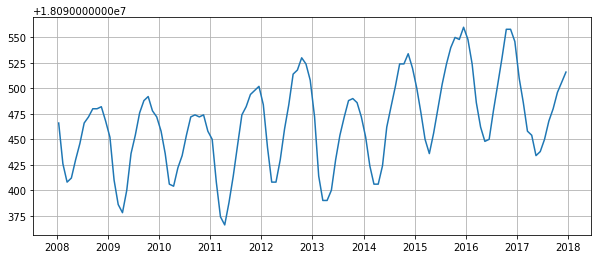

In [11]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(OBP_global_mean_mon.time,OBP_global_mean_mon)
ax.grid()

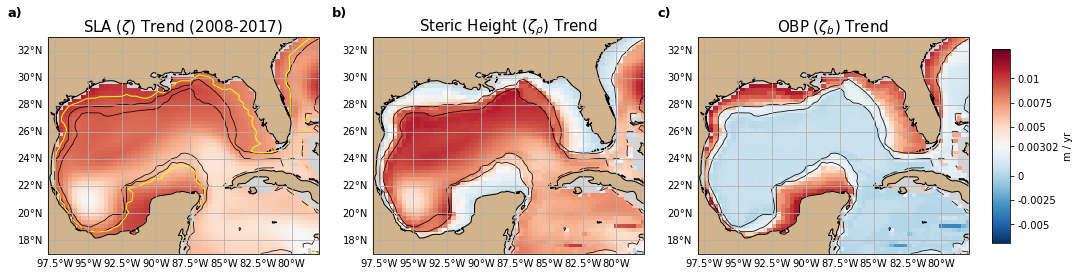

In [100]:
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 
colMap = plt.get_cmap('RdBu_r')
cmin = 0.0030186245502099134 - 0.01
cmax = 0.0030186245502099134 + 0.01
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

f, (ax,ax3,ax2) = plt.subplots(1,3,figsize=(16.5,4.5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})

skill = 1 - ((rho0*g*ssh_anom.isel(tile=tile_num) - obp_anom.isel(tile=tile_num)).var(dim='time')) / \
             ((rho0*g*ssh_anom.isel(tile=tile_num)).var(dim='time'))

pes = pssh.polyfit_coefficients.sel(tile=tile_num,degree=1).data*1e9*60*60*24*365
cc = ax.pcolor(lons, lats, pes*ocean_mask.sel(tile=tile_num), transform=ccrs.PlateCarree(),cmap=colMap,vmin=cmin,vmax=cmax); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, skill, [0.65], linewidths=1, colors='#ffff00', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_facecolor('#D3D3D3'); ax.grid(); # ax.set_xticks([-95,-90,-85,-80]) 
ax.set_title(r'SLA ($\zeta$) Trend (2008-2017)',fontsize=15)
ax.set_xlabel('Longitude',fontsize=14); ax.set_ylabel('Latitude',fontsize=14)

cc = ax2.pcolor(lons, lats, pobp.polyfit_coefficients.sel(tile=tile_num,degree=1)*1e9*60*60*24*365/g/rho0, transform=ccrs.PlateCarree(),cmap=colMap,vmin=cmin,vmax=cmax); 
ax2.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax2.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])
ax2.set_facecolor('#D3D3D3'); ax2.grid(); 
ax2.set_title(r'OBP ($\zeta_b$) Trend',fontsize=15)

pes = pster.polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365/g/rho0
cc = ax3.pcolor(lons, lats, pes*ocean_mask.sel(tile=tile_num), transform=ccrs.PlateCarree(),cmap=colMap,vmin=cmin,vmax=cmax); 
ax3.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax3.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax3.coastlines()
gl = ax3.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax3.set_xlim([lon_w, lon_e]); ax3.set_ylim([lat_s, lat_n])
ax3.set_facecolor('#D3D3D3'); ax3.grid(); 
ax3.set_title(r'Steric Height ($\zeta_{\rho}$) Trend',fontsize=15)

cbpos = [0.92, 0.2, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='neither', label='m / yr', ticks=[-0.005,-0.0025,0,0.003018,0.005,0.0075,0.01])
cb.set_ticklabels(['-0.005','-0.0025','0','0.00302','0.005','0.0075','0.01'])
ax.text(lon_w-3,lat_n+1.5,'a)',fontsize=13,fontweight='bold')
ax2.text(lon_w-3,lat_n+1.5,'c)',fontsize=13,fontweight='bold')
ax3.text(lon_w-3,lat_n+1.5,'b)',fontsize=13,fontweight='bold')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/ecco_ssh_obp_ster_scb.jpg', dpi=250)

In [12]:
pes = pssh.polyfit_coefficients.sel(tile=tile_num,degree=1).data*1e9*60*60*24*365
pes[np.where(pes < -0.0026)] = np.nan
pes[np.where(pes < -0.0026)]

array([], dtype=float64)

Text(0.5, 1.0, 'Skill: Steric Height, SLA Correspondence')

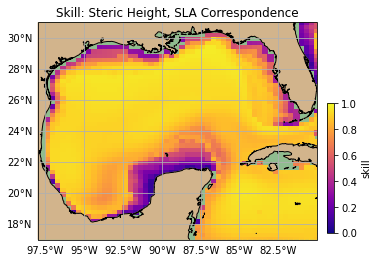

In [14]:
# show correspondence between SLA, OBP, and steri height as a function of depth 
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
skill = 1 - ((s_press.isel(tile=tile_num) - (ster)).var(dim='time')) / \
             ((s_press.isel(tile=tile_num)).var(dim='time'))
colMap = plt.get_cmap('plasma');
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc =ax.pcolor(lons, lats, skill, transform=ccrs.PlateCarree(),cmap=colMap,vmin=0,vmax=1); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.86, 0.15, 0.015, 0.45]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='neither', label='skill')
ax.set_title('Skill: Steric Height, SLA Correspondence')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_ecco_sla_ster_skill.jpg', dpi=250)

In [13]:
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

(17.0, 31.0)

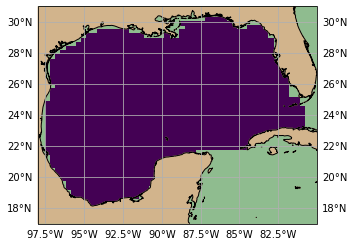

In [14]:
# PLOT mask 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lons, lats, gulf_mask, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [15]:
da_gulf_mask = xr.DataArray(data=np.transpose(gulf_mask.data), dims=["lat","lon"],
                        coords=dict(
                            lon=(["lon"], np.nanmean(gulf_mask.XC,axis=1)),
                            lat=(["lat"], np.nanmean(gulf_mask.YC,axis=0)),
                        ),
                       )

(17.0, 31.0)

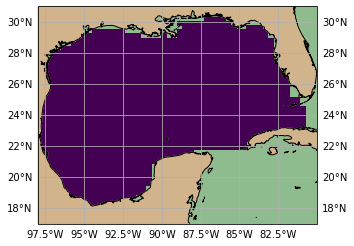

In [64]:
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(np.nanmean(gulf_mask.XC,axis=1), np.nanmean(gulf_mask.YC,axis=0), np.transpose(gulf_mask.data), transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [68]:
# -- save mask -- 
# gulf_mask.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/ecco_gulf_mask_4.nc')

In [20]:
# linear trend in theta after applying gulf mask
# -- temperature -- 
theta = ds_theta_r*gulf_mask
theta_a = theta - theta.mean(dim='time')
ptheta = theta_a.polyfit(dim='time', deg=1)

In [49]:
gom_theta_a = theta_a.mean(dim=['i','j'])

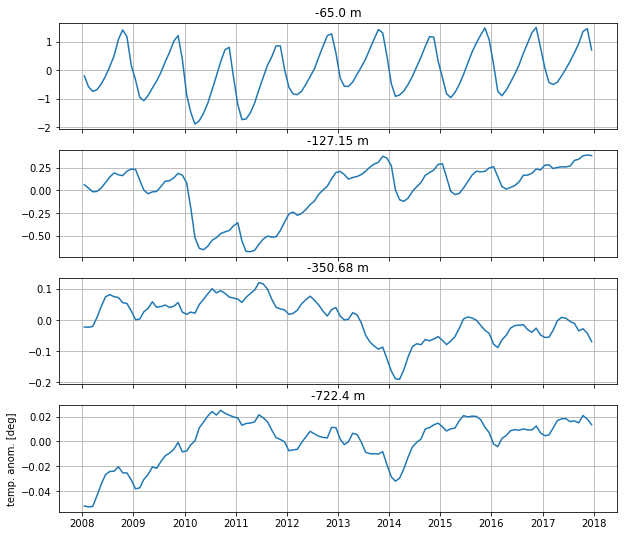

In [60]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,9))
ax1.plot(theta_a.time,gom_theta_a.isel(layer=6))
ax1.set_title(str(ecco_grid.Z[6].data) + ' m'); ax1.set_xticklabels(['']); 
ax1.grid()
ax2.plot(theta_a.time,gom_theta_a.isel(layer=12))
ax2.set_title(str(ecco_grid.Z[12].data) + ' m'); ax2.set_xticklabels([''])
ax2.grid()
ax3.plot(theta_a.time,gom_theta_a.isel(layer=20))
ax3.set_title(str(ecco_grid.Z[20].data) + ' m'); ax3.set_xticklabels([''])
ax3.grid()
ax4.plot(theta_a.time,gom_theta_a.isel(layer=25))
ax4.set_title(str(ecco_grid.Z[25].data) + ' m'); ax4.set_ylabel('temp. anom. [deg]')
ax4.grid()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/GOM_ecco_theta_anom.jpg', dpi=250)

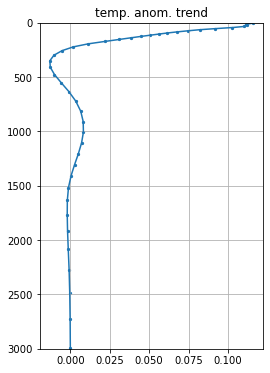

In [63]:
imast = ecco_monthly_ds.drF.data.cumsum()
f, ax = plt.subplots(1,1,figsize=(4,6))
ax.plot(ptheta.polyfit_coefficients.isel(degree=0).mean(dim=['i','j'])*1e9*60*60*24*365,-1*ecco_grid.Z)
ax.scatter(ptheta.polyfit_coefficients.isel(degree=0).mean(dim=['i','j'])*1e9*60*60*24*365,-1*ecco_grid.Z,s=5)
ax.set_ylim([0,3000]); ax.invert_yaxis()
ax.grid(); ax.set_title('temp. anom. trend')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/GOM_ecco_theta_anom_trend.jpg', dpi=250)

In [16]:
# -- extract linear OBP trend (from OBP anomaly (subtracted global mean time series and local time mean)
# -- remove GOM mean trend (import of mass into basin)
fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
gulf_area = np.nansum(gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
gulf_t_obp = fitloc*gulf_mask
gulf_a_obp = gulf_t_obp - mean_gulf_trend
print(mean_gulf_trend)

0.0030362258595405833


In [17]:
gulf_area

1515255500000.0

(17.0, 31.0)

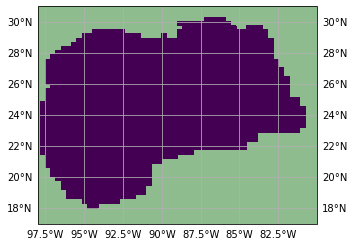

In [65]:
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(np.nanmean(gulf_mask.XC,axis=1), np.nanmean(gulf_mask.YC,axis=0), np.transpose(gulf_mask.data), transform=ccrs.PlateCarree()); ax.grid(); 
# ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s, lat_n])

In [18]:
# mean gulf time series 
mean_gulf_timeseries = (obp_anom.isel(tile=tile_num)*gulf_mask).mean(dim=['j','i'])

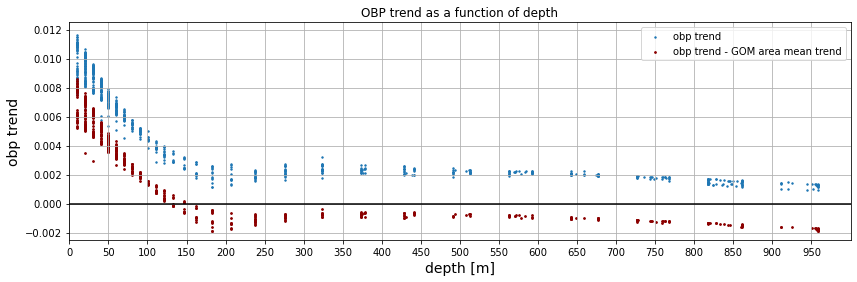

In [19]:
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,1500],[0, 0], color='k', linewidth=1.5)
lon_sub = np.where((lons > lon_range[0]) & (lons < lon_range[-1]))[0]; lat_sub = np.where((lats > lat_range[0]) & (lats < lat_range[-1]))[1]
ax.scatter(dep.isel(tile=tile_num).data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], \
           fitloc.data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], s=2, label='obp trend'); 
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=3, color='#8B0000', label='obp trend - GOM area mean trend'); 
ax.set_xlim([0,1000]); ax.set_ylim([-0.0025,0.0125]);
ax.set_xticks(np.arange(0,1000,50));
# ax.set_xticklabels(['0','25','50','75','100','125','150','175'])
ax.grid(); ax.set_xlabel('depth [m]', fontsize=14); ax.set_ylabel('obp trend', fontsize=14);
ax.set_title('OBP trend as a function of depth');
ax.legend()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_24/GOM_obp_vs_dep.jpg', dpi=250)

Text(0.5, 1.0, 'OBP trend - GOM mean (0.003 m/year)')

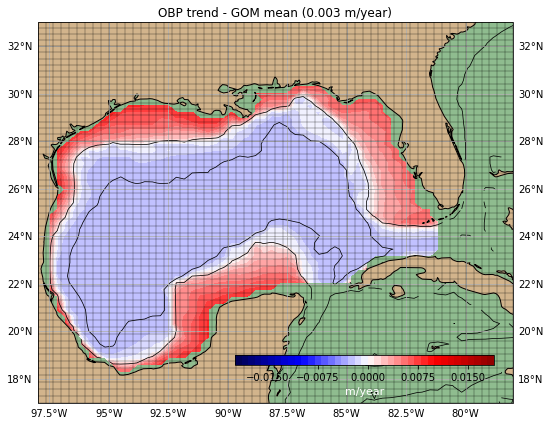

In [131]:
f, ax = plt.subplots(1,1,figsize=(9,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); clim = [-0.02, 0.02];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, transform=ccrs.PlateCarree()); 
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [2000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())

# ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

cbpos = [0.45, 0.2, 0.4, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='horizontal', label='m/year',ticks=[-0.015, -0.0075, 0, 0.0075, 0.015])
cb.set_label(label='m/year', color='w', fontsize=11)
ax.set_title('OBP trend - GOM mean (' + str(np.round(mean_gulf_trend,4)) + ' m/year)')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_obp_trend_anom.jpg', dpi=250)

Text(0.5, 1.0, 'area of layer w/ bottom dep = 1255.54 = A$_s$ minus shaded region')

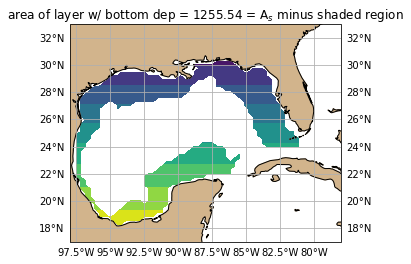

In [134]:
# check on area calculation below 
testi = 30; test = A.where(h <= imast[testi], np.nan); 
f, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.contourf(lons,lats,test)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('w'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_title(r'area of layer w/ bottom dep = ' + str(imast[testi]) + ' = A$_s$ minus shaded region')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_layer_i_area.jpg', dpi=250)

In [20]:
# surface and layer areas 
h = dep.isel(tile=tile_num)                                 # depth 
A = ecco_monthly_ds.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_monthly_ds.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)

# print(imast)
# print(100*(AA/gulf_area))
# percent of total area decreases as layer index increases (as we go deeper )
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [21]:
GOM_mask_plot = gulf_mask.data.copy()
GOM_mask_plot[np.isnan(GOM_mask_plot)] = 0

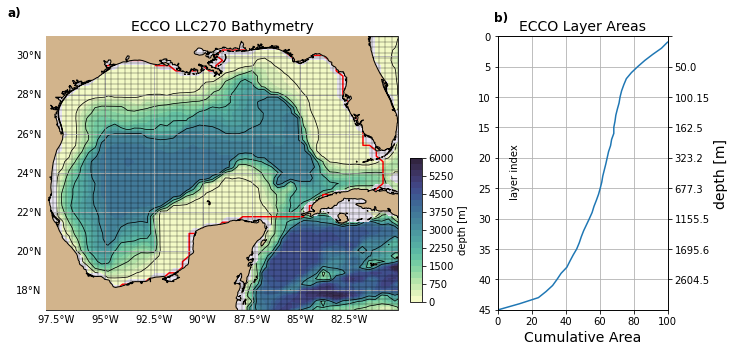

In [31]:
# f, ax = plt.subplots(1,1,figsize=(5,7))
# f, ax = plt.subplots(1,1,figsize=(9,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); clim = [-0.02, 0.02];
fig = plt.figure(tight_layout=True,figsize=(11,5))
gs = gridspec.GridSpec(1, 4)
ax = fig.add_subplot(gs[0, 0:3], projection = ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[0, 3])

colMap = cmo.cm.deep;  
colMap.set_over(color=colMap(1));
Kc = ax.contourf(lons,lats,dep.isel(tile=tile_num), levels=np.arange(0,6250,250), vmin=0, vmax=6250, cmap=colMap, transform=ccrs.PlateCarree()); # levels=np.arange(0,4750,250),
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [2000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [3000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(np.nanmean(gulf_mask.XC,axis=1), np.nanmean(gulf_mask.YC,axis=0), \
           np.transpose(GOM_mask_plot), [1], transform=ccrs.PlateCarree(), zorder=2, colors='r', linewidth=3);
ax.add_feature(cartopy.feature.LAND, color='#D2B48C', zorder=3); ax.coastlines(zorder=3)
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; 
ax.set_facecolor('#e8e4f2'); # ax.set_facecolor('#8EF7F7'); 
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.585, 0.15, 0.015, 0.4]; cax = fig.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', label='depth [m]')
ax.set_title('ECCO LLC270 Bathymetry', fontsize=14)

ax2.plot(np.round(100*(AAi.data/gulf_area),1),np.arange(1,len(AAi)+1))
ax2.grid(); 
ax2.text(7,26.5,'layer index',fontsize=10,rotation=90); 
ax2.set_xlabel('Cumulative Area',fontsize=14);
ax2.set_ylim([0,45]); ax2.invert_yaxis(); 
ax3 = ax2.twinx()
# ax2.plot(np.round(100*(AAi.data/gulf_area),1),imast)
ax3.set_yticks(np.arange(0,1,1/9))
ax3.set_yticklabels(['',str(imast[4]),str(imast[9]),str(np.round(imast[14],1)),str(np.round(imast[19],1)),\
                     str(np.round(imast[24],1)),\
                    str(np.round(imast[29],1)),str(np.round(imast[34],1)),str(np.round(imast[39],1))])
ax3.invert_yaxis(); ax3.set_ylabel('depth [m]',fontsize=14)
ax2.set_title('ECCO Layer Areas',fontsize=14); ax2.set_xlim([0,100])
ax.text(lon_w-2,lat_n+1,'a)',fontsize=12,fontweight='bold')
ax2.text(-2.5,-2.5,'b)',fontsize=12,fontweight='bold'); ax.grid()
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/ecco_bathy.jpg', dpi=250)

(-1000.0, 0.0)

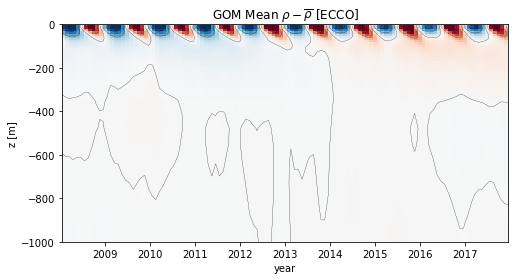

In [22]:
rho_ECCO_0 = ds_den_r*gulf_mask
rho_ECCO_1 = ds_den_r.mean(dim=['j','i'])
f, ax = plt.subplots(1,1,figsize=(8,4))
pp = ax.pcolor(rho_ECCO_1.time,ecco_grid.Z,(rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose(), cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.contour(rho_ECCO_1.time,ecco_grid.Z,(rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose(), level=[0], colors='k',linewidths=0.25)
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [ECCO]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); # ax.set_xlim([t_s, t_e])
ax.set_ylim([-1000,0])
# cbpos = [0.93, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_ecco_rho_pr.jpg', dpi=250)

In [ ]:
# -- Landerer model choices (what to use for rho') -- 
# -- CAN SKIP AND JUST USE RHO 
# -- density anomaly defined relative to local time mean 
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
# -- density anomaly defined relative to rho0 
rho_a_rho0 = ds_den_r - rho0
p_rho0 = rho_a_rho0.polyfit(dim='time', deg=1)
rho_a_rho0_trend = xr.polyval(rho_a_rho0['time'], p_rho0.polyfit_coefficients)

In [23]:
# -- Run Landerer Model --
time0 = time.time()
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
# v_cell_z = np.cumsum(ecco_grid.drF.data)[0:45]                          # cumulative sum --> layer depths 
v_cell_z = ecco_grid.Z[0:45]                                                  # depth of vertical cell center 

delta_pb_total = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
lay1 = np.nan*np.ones((np.shape(ds_den_r)[0]))
layb = np.nan*np.ones((np.shape(ds_den_r)[0],len(v_cell_z)-1))
# -- main loop -- 
for tt in range(np.shape(ds_den_r)[0]):                                 # loop over all times 
    for m in range(0,45):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]                   # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/AAi.isel(layer=above_i) - 1)*(AAi.isel(layer=above_i)/As)*\
                           (v_cell_t.isel(layer=above_i)*\
                           -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

    # -- consider individual output contributions ONLY to layer 1 --
    m = 0
    this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
    this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    below_i = np.arange(this_i+1,len(v_cell_z))
    above_i = np.arange(0,this_i+1)
    above_1 = (1/rho0)*((As/AAi.isel(layer=above_i) - 1)*(AAi.isel(layer=above_i)/As)*\
                      (v_cell_t.isel(layer=above_i)*\
                       -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    below_1 = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i']) )
    # below should have dimensions len(v_cell_z) - 1
    # above should have dimensions 1x1 
    lay1[tt] = above_1.data 
    layb[tt,:] = below_1.data
        
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], ds_den_r.layer.data[0:len(pbdeps)]),
                            time=(["time"], ecco_monthly_ds.time.data),
                        ),
                       )
lay1_da = xr.DataArray(data=lay1, dims=["time"],
                        coords=dict(time=(["time"], ecco_monthly_ds.time.data)),
                       )
layb_da = xr.DataArray(data=np.transpose(layb), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data[1:]),
                            time=(["time"], ecco_monthly_ds.time.data)),
                       )
# did stuff
elapsed = time.time() - time0
print(elapsed) # in seconds 

336.74905800819397


In [24]:
# select depths/obp for tile 10 
obpi = obp_anom.isel(tile=tile_num) # obp.isel(tile=tile_num)*gulf_mask; 
depi = dep.isel(tile=tile_num);
# obpi_in = obpi.where((depi > -1*v_cell_z[i-1].data) & (depi <= -1*v_cell_z[i].data))

In [25]:
# -- obp anomaly as a function of depth and time (this is what the above delta pb is estimating )
obpi = (obp_anom.isel(tile=tile_num) - mean_gulf_timeseries)*gulf_mask # obp.isel(tile=tile_num)*gulf_mask; 
depi = dep.isel(tile=tile_num);
delta_pb_obs = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
delta_pb_obs_w = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
delta_pb_obs_e = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
for i in range(len(v_cell_z)):
    if i < 1:
        obpi_in = obpi.where(depi <= -1*v_cell_z[i].data)
        delta_pb_obs[:,i] = obpi_in.mean(dim=['j','i'])  # .isel(j=np.where(lons < -90)[0],i=np.where(lons < -90)[1])
        # delta_pb_obs_e[:,i] = obpi_in.mean(dim=['j','i'])  # isel(j=np.where(lons > -90)[0],i=np.where(lons > -90)[1])
    else:
        obpi_in = obpi.where((depi > -1*v_cell_z[i-1].data) & (depi <= -1*v_cell_z[i].data) )
        delta_pb_obs[:,i] = obpi_in.mean(dim=['j','i'])
        # delta_pb_obs_e[:,i] = obpi_in.mean(dim=['j','i'])

In [26]:
# -- convert to ordinal time
time_ord = np.nan*np.ones(len(ecco_monthly_ds.time))
for i in range(len(ecco_monthly_ds.time)):
    ts = (np.datetime64(str(ecco_monthly_ds.time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
# -- check conversion 
print(str(ecco_monthly_ds.time[0].data)[0:10])
ts = (np.datetime64(str(ecco_monthly_ds.time[0].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
tday = ts/(60*60*24)
print(tday)
datetime.fromordinal(int(tday)) + dt.timedelta(days=tday%1) - dt.timedelta(days=365)

2008-01-16
733422.0


datetime.datetime(2008, 1, 16, 0, 0)

In [27]:
# A*sin((2pi/365)*t + B) + C*cos((2pi/365)*t + D) + E*x + F 
def trend_season_f(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 
    # my attempt: a*np.sin((2*np.pi/365)*x+b) + c*np.cos((2*np.pi/365)*x+d) + e*x + f 
    # chris: a*sin((2pi/365)*t+b) + c*sin((2pi/(365/2))*t+d) + e*t + f;

def trend_f(x,e,f):
    return e*x + f 

def season_f(x,a,b,c,d):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.cos((2*np.pi/365)*x+d)

# ECCO OBP anomaly
pb_obs_a = (np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0)
# ECCO density predicted OBP trend
pb_est_a = (deltapbz_total - deltapbz_total.mean(dim=['time']))

pb_obs_a_model = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_model = np.nan*np.ones(np.shape(pb_obs_a))
pb_obs_a_no_season = np.nan*np.ones(np.shape(pb_obs_a))
pb_obs_a_no_trend = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_no_season = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_no_trend = np.nan*np.ones(np.shape(pb_obs_a))
for i in range(1,np.shape(pb_obs_a)[0]):
    d_i = i
    fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_obs_a[d_i,:]) # fit function (trend_season_f) to data 
    model_total = trend_season_f((time_ord-time_ord[0]),*fit[0])           # reconstruct based on fitted parameters 
    model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])      # reconstruct trend only 
    model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])  # reconstruct seasonal cycle only 
    # obp seasonal + trend
    pb_obs_a_model[d_i,:] = model_total
    # obp w/ seasonal cycle removed 
    pb_obs_a_no_season[d_i,:] = pb_obs_a[d_i,:] - model_season
    # obp w/ trend removed
    pb_obs_a_no_trend[d_i,:] = pb_obs_a[d_i,:] - model_trend
    
    fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_est_a[d_i,:])
    model_total = trend_season_f((time_ord-time_ord[0]),*fit[0])
    model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
    model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    model_season_plus_trend = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    # est seasonal + trend
    pb_est_a_model[d_i,:] = model_total
    # est w/ seasonal cycle removed 
    pb_est_a_no_season[d_i,:] = pb_est_a[d_i,:] - model_season   # TREND ONLY
    # est w/ trend removed
    pb_est_a_no_trend[d_i,:] = pb_est_a[d_i,:] - model_trend     # SEASON ONLY

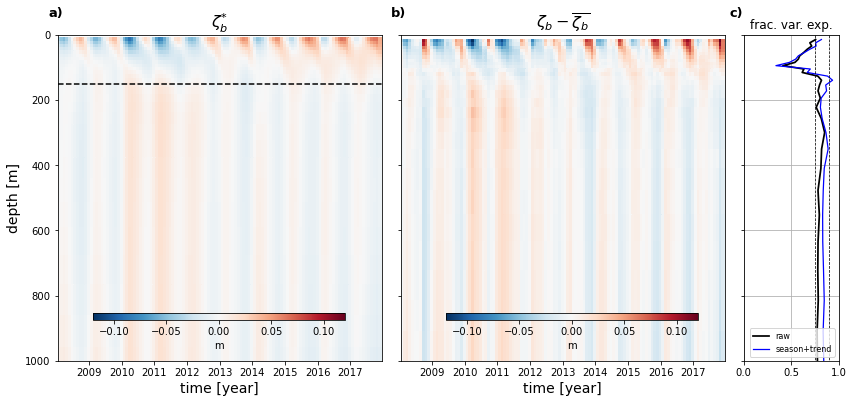

In [31]:
fig = plt.figure(figsize=(14,6))
gs = GridSpec(1, 7, figure=fig)
ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[0,3:6])
ax3 = fig.add_subplot(gs[0,6])
Kc=ax1.pcolor(ecco_monthly_ds.time,pbdeps,deltapbz_total - deltapbz_total.mean(dim=['time']),cmap='RdBu_r',vmin=-0.12,vmax=0.12)
# ax1.contour(rho_ECCO_1.time,-1*ecco_grid.Z,(rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose(), \
#             level=[0], colors='k',linewidths=0.75, zorder=2)
ax1.plot(ecco_monthly_ds.time,150*np.ones(len(ecco_monthly_ds.time)),color='k',linestyle='--')
ax1.set_ylabel('depth [m]',fontsize=14); ax1.set_xlabel('time [year]',fontsize=14); ax1.set_ylim([0,1000]);
# ax1.set_title(r'$\frac{1}{g\rho_0} \left( p_b(t,z) - \overline{p_b(z)}\right)$',fontsize=15); 
ax1.set_title(r'$\zeta_{b}^{*}$',fontsize=16); ax1.invert_yaxis()

ax2.pcolor(ecco_monthly_ds.time,-1*v_cell_z,np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0,cmap='RdBu_r',vmin=-0.12,vmax=0.12)
ax2.set_yticklabels(['']); ax2.set_xlabel('time [year]',fontsize=14); ax2.set_ylim([0,1000]);
ax2.set_title(r"$\zeta_{b} - \overline{\zeta_{b}}$",fontsize=16); ax2.invert_yaxis()

# pb_obs_a = (np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0)
# pb_est_a = (deltapbz_total - deltapbz_total.mean(dim=['time']))

pb_skill = 1 - np.nanvar(pb_obs_a - pb_est_a, axis=1)/np.nanvar(pb_obs_a,axis=1)
pb_skill_model = 1 - np.nanvar(pb_obs_a_model - pb_est_a_model, axis=1)/np.nanvar(pb_obs_a_model,axis=1)
pb_skill_wo_trend = 1 - np.nanvar(pb_obs_a_no_trend - pb_est_a_no_trend, axis=1)/np.nanvar(pb_obs_a_no_trend,axis=1)
pb_skill_wo_season = 1 - np.nanvar(pb_obs_a_no_season - pb_est_a_no_season, axis=1)/np.nanvar(pb_obs_a_no_season,axis=1)

cbpos = [0.16, 0.22, 0.25, 0.015]; cax = fig.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='horizontal', label='m')
cbpos = [0.51, 0.22, 0.25, 0.015]; cax = fig.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='horizontal', label='m')

ax3.plot(pb_skill,-1*v_cell_z,color='k',linewidth=1.75, label='raw')
ax3.plot(pb_skill_model,-1*v_cell_z,color='b',linewidth=1.25, label='season+trend')
# ax3.plot(pb_skill_wo_trend,-1*v_cell_z,color='g',linewidth=1.25, label='w/o trend')
# ax3.plot(pb_skill_wo_season,-1*v_cell_z,color='m',linewidth=1.25, label='w/o season')
# ax3.plot([0,0],[0,1000],color='k',linestyle='-',linewidth=1.25)
ax3.plot([0.75,0.75],[0,1000],color='k',linestyle='--',linewidth=0.75)
ax3.plot([0.9,0.9],[0,1000],color='k',linestyle='--',linewidth=0.75)
# ax3.plot([-0.35,-0.35],[0,1000],color='k',linestyle='--',linewidth=0.75)
# ax3.plot([0.35,0.35],[0,1000],color='k',linestyle='--',linewidth=0.75)
ax3.set_yticklabels(['']); ax3.set_xlim([0,1]); ax3.set_ylim([0,1000]);
# ax3.set_xlabel(r"1 - $\frac{\langle p_b' - OBP_a' \rangle}{\langle OBP_a' \rangle}$",fontsize=14); ax3.set_title(r'skill',fontsize=14); 
ax3.set_title('frac. var. exp.') 
ax3.invert_yaxis(); ax3.grid(); ax3.legend(loc=4,fontsize=8)

ax1.text(np.datetime64('2007-10-01'),-55,'a)',fontsize=13,fontweight='bold')
ax2.text(np.datetime64('2007-10-01'),-55,'b)',fontsize=13,fontweight='bold')
ax3.text(-0.15,-55,'c)',fontsize=13,fontweight='bold')

# cbpos = [0.92, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/landerer_predicted_vs_model_obp.jpg', dpi=350)
# fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_21/landerer_predicted_vs_model_obp.jpg', dpi=350)

In [111]:
ecco_monthly_ds.time[0]
np.datetime64('2007-10-01')

<xarray.DataArray 'time' ()>
array('2008-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    timestep  int64 423000
    time      datetime64[ns] 2008-01-16T12:00:00
Attributes:
    standard_name:  time
    long_name:      center time of averaging period
    axis:           T

In [38]:
ds_argo = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/argo_obp_50m_2010_2019.nc')
ds_grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/grace_obp_100m_2010_2019.nc')

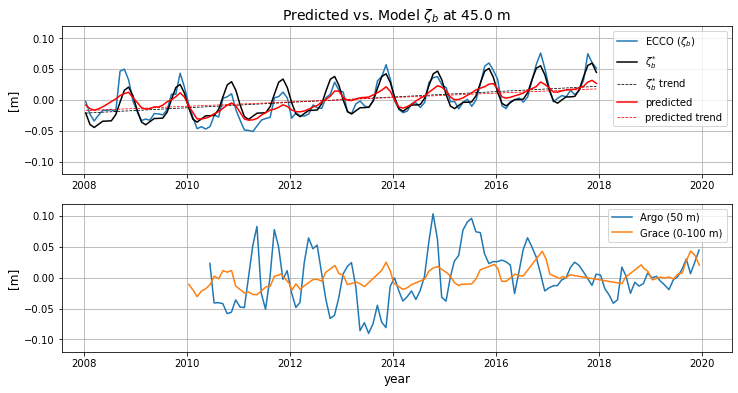

In [89]:
d_i = 4 # depth index 
fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_obs_a[d_i,:])
model = trend_season_f((time_ord-time_ord[0]),*fit[0])
model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])

f, (ax,ax2) = plt.subplots(2,1,figsize=(12,6),sharey=True)
ax.plot(ecco_monthly_ds.time, pb_obs_a[d_i,:], label=r'ECCO ($\zeta_b$)') 
ax.plot(ecco_monthly_ds.time, model, color='k', linestyle='-', label=r'$\zeta_b^{*}$')
ax.plot(ecco_monthly_ds.time, model_trend, color='k', linestyle='--', linewidth=0.75, label=r'$\zeta_b^{*}$ trend')

fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_est_a[d_i,:])
model = trend_season_f((time_ord-time_ord[0]),*fit[0])
model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])

ax.plot(ecco_monthly_ds.time, pb_est_a[d_i,:], color='r',label='predicted')
ax.plot(ecco_monthly_ds.time, model_trend, color='r', linestyle='--', linewidth=0.75, label='predicted trend')

ax.set_ylim([-0.12,0.12]); ax.set_ylabel('[m]',fontsize=12); ax.legend() 
ax.set_title(r'Predicted vs. Model $\zeta_b$ at ' + str(-1*v_cell_z[d_i].data) + ' m', fontsize=14)
ax.grid(); 
ax.set_xlim([np.datetime64('2007-08-01'),np.datetime64('2020-08-01')])

ax2.plot(ds_argo.time,ds_argo.argo_obp,label='Argo (50 m)')
ax2.plot(ds_grace.time,ds_grace.grace_obp, label='Grace (0-100 m)')
ax2.set_xlim([np.datetime64('2007-08-01'),np.datetime64('2020-08-01')])
ax2.grid(); ax2.legend(); ax2.set_ylabel('[m]',fontsize=12)
ax2.set_xlabel('year',fontsize=12)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_21/predicted_vs_obs_obp_all.jpg', dpi=350)

In [93]:
np.datetime64('2020-02-01')

numpy.datetime64('2020-02-01')

In [94]:
ds_argo.time[-1]

<xarray.DataArray 'time' ()>
array('2019-12-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-12-15

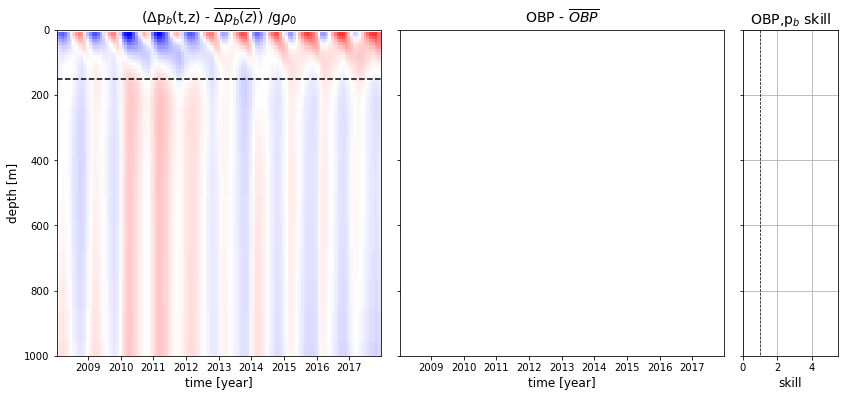

In [166]:
fig = plt.figure(figsize=(14,6))
gs = GridSpec(1, 7, figure=fig)
ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[0,3:6])
ax3 = fig.add_subplot(gs[0,6])
Kc=ax1.pcolor(ecco_monthly_ds.time,pbdeps,deltapbz_total - deltapbz_total.mean(dim=['time']),cmap='bwr',vmin=-0.08,vmax=0.08)
ax1.plot(ecco_monthly_ds.time,150*np.ones(len(ecco_monthly_ds.time)),color='k',linestyle='--')
ax1.set_ylabel('depth [m]',fontsize=12); ax1.set_xlabel('time [year]',fontsize=12); ax1.set_ylim([0,1000]);
ax1.set_title(r'($\Delta$p$_b$(t,z) - $\overline{\Delta p_b(z)}$) /g$\rho_0$',fontsize=14); ax1.invert_yaxis()

ax2.pcolor(ecco_monthly_ds.time,v_cell_z,np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0,cmap='bwr',vmin=-0.08,vmax=0.08)
ax2.set_yticklabels(['']); ax2.set_xlabel('time [year]',fontsize=12); ax2.set_ylim([0,1000]);
ax2.set_title(r'OBP - $\overline{OBP}$',fontsize=14); ax2.invert_yaxis()

pbskill = np.nanvar((np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0) - \
                    (deltapbz_total - deltapbz_total.mean(dim=['time'])), axis=1)/np.nanvar(np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0,axis=1)
ax3.plot(pbskill,v_cell_z,color='k',linewidth=1.5)
ax3.plot([1,1],[0,1000],color='k',linestyle='--',linewidth=0.75)
ax3.set_yticklabels(['']); ax3.set_xlabel('skill',fontsize=12); ax3.set_xlim([0,5.5]); ax3.set_ylim([0,1000]);
ax3.set_title(r'OBP,p$_b$ skill',fontsize=14); ax3.invert_yaxis(); ax3.grid()

# cbpos = [0.92, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_obp_landerer_in_time.jpg', dpi=250)

In [33]:
# -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
test = (deltapbz_total - deltapbz_total.mean(dim=['time']))
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# test_upper = (deltapbz_total_upper - deltapbz_total_upper.mean(dim=['time']))
# p_test_upper = test_upper.polyfit(dim='time', deg=1)
# p_test_upper = (p_test_upper.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [97]:
# subset for times when we have argo data 
t_s = '2009-01-01'
t_e = '2017-12-31'
test8 = test.sel(time=slice(t_s, t_e))
p_test8 = test8.polyfit(dim='time', deg=1)
p_test8 = (p_test8.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

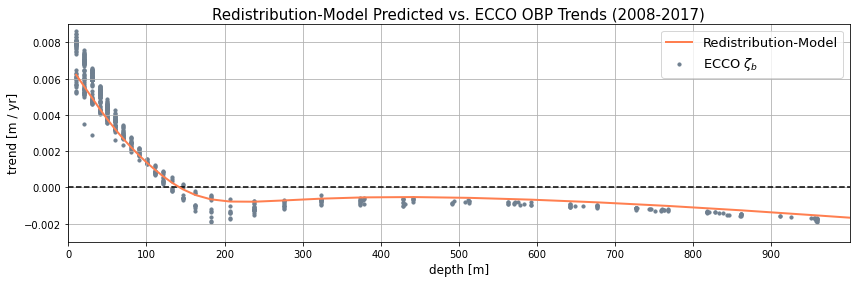

In [104]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=10, color='#708090',label="ECCO $\zeta_{b}$"); 
# ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_sla, s=1, color='m',label='sla trend'); 
ax.plot(pbdeps, p_test, color='#FF7F50', linewidth=2, label='Redistribution-Model')
# ax.plot(pbdeps, p_test8, color='r', linewidth=2, label='Landerer8')
# ax.plot(pbdeps, p_test_upper, color='#32CD32', linewidth=1.5, label='Landerer in time 0-' + str(np.int(v_cell_z[29])) + 'm')
ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=12)
ax.set_ylim([-0.003, 0.009]); ax.set_ylabel('trend [m / yr]',fontsize=12)
ax.grid(); ax.set_title("Redistribution-Model Predicted vs. ECCO OBP Trends (2008-2017)",fontsize=15); 
ax.legend(fontsize=13)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/landerer_predicted_trend.jpg', dpi=250)

In [234]:
ecco_landerer_trend = xr.Dataset(
    data_vars=dict(
        p_test=(['depth'], p_test.data),
        p_test8=(['depth'], p_test8.data),
    ),
    coords=dict(
        depth=(["depth"], pbdeps)
    ),
)
ecco_landerer_trend.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/ecco_landerer_trend_prediction.nc')

In [29]:
t_s = '2008-01-15'
t_e = '2017-12-15'
test1_time = ecco_monthly_ds.time.data
test1 = lay1_da.sel(time=slice(t_s, t_e))
testb = layb_da.sel(time=slice(t_s, t_e))
layerbylayer = testb.cumsum(dim='zi') - test1
layerbylayer_a = layerbylayer - layerbylayer.mean(dim=['time'])
p1_test = layerbylayer_a.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

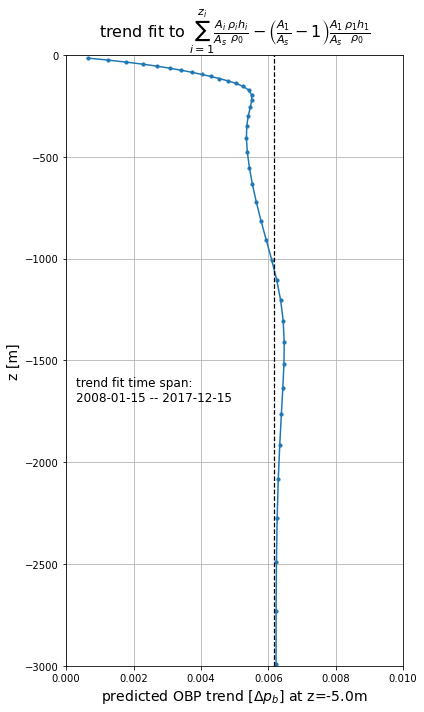

In [31]:
# contributions to layer 1 
f, ax = plt.subplots(1,1,figsize=(6,10))
ax.plot(p1_test,v_cell_z[1:],linewidth=1.5); ax.scatter(p1_test,v_cell_z[1:],s=10)
ax.plot([p_test[0],p_test[0]],[-3000,0],linestyle='--',color='k',linewidth=1.25)
ax.grid(); ax.set_xlabel(r'predicted OBP trend [$\Delta p_b$] at z='+str(v_cell_z[0].data)+'m',fontsize=14)
ax.set_ylabel('z [m]',fontsize=14)
ax.set_title(r'trend fit to $\sum_{i=1}^{z_i} \frac{A_i}{A_s} \frac{\rho_i h_i}{\rho_0} - \left(\frac{A_1}{A_s} - 1 \right) \frac{A_1}{A_s} \frac{\rho_1 h_1}{\rho_0}$',\
            fontsize=16)
ax.text(0.0003,-1625,'trend fit time span:',fontsize=12)
ax.text(0.0003,-1700,'2008-01-15 -- 2017-12-15',fontsize=12)
ax.set_ylim([-3000,0]); ax.set_xlim([0,0.01])
f.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/predicted_obp_trend_level1.jpg', dpi=250)

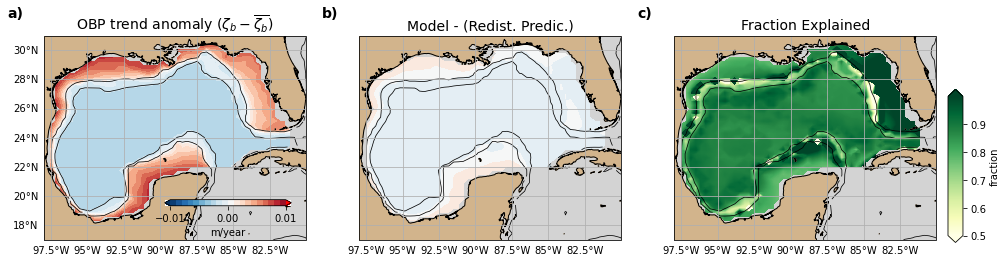

In [36]:
landerer_total_xy = np.nan*np.ones(np.shape(gulf_a_obp))
for i in range(np.shape(gulf_a_obp)[0]):
    for j in range(np.shape(gulf_a_obp)[1]):
        this_dep = dep.isel(tile=tile_num)[j,i].data
        if ~np.isnan(this_dep):
            bot_ind = np.where(pbdeps <= this_dep)[0]
            if len(bot_ind >= 1):
                landerer_total_xy[j,i] = p_test[bot_ind[-1]]

f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(16,4.25), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); 
clim = [-0.01, 0.011];
colMap = plt.get_cmap('RdBu_r'); 
colMap.set_over(color='r');
ocean = '#D3D3D3' #'#00FFFF'

Kc0 = ax.contourf(lons,lats, gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both', transform=ccrs.PlateCarree()); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.set_facecolor(ocean); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;

Kc = ax2.contourf(lons,lats, gulf_a_obp - landerer_total_xy, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both', transform=ccrs.PlateCarree()); 
ax2.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax2.set_facecolor(ocean); 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_left = False; gl.ylabels_right = False; gl.xlabels_top = False;

Kc = ax3.contourf(lons,lats, (landerer_total_xy)/gulf_a_obp, levels=np.arange(0.5,1.001,0.001), \
            vmin=0.5,vmax=1, extend='both', cmap='YlGn', transform=ccrs.PlateCarree()); 
ax3.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax3.set_facecolor(ocean); 
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax3.coastlines()
gl = ax3.gridlines(draw_labels=True); gl.ylabels_left = False; gl.ylabels_right = False; gl.xlabels_top = False;

# lon_site_i = -90.5; lat_site_i = 28.25
# ecli = np.where((lons > lon_site_i-.65) & (lons < lon_site_i+.65) & (lats > lat_site_i-.65) & (lats < lat_site_i+.65))
# ax3.scatter(lon_site_i,lat_site_i,s=10,color='w')

ax.set_title('OBP trend anomaly ($\zeta_b - \overline{\zeta_b}$)',fontsize=14)
# ax.text(-97,31,'(mean=' + str(np.round(mean_gulf_trend,5)) + ' m / yr)')
ax2.set_title('Model - (Redist. Predic.)',fontsize=14)
ax3.set_title('Fraction Explained',fontsize=14)

ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])
ax3.set_xlim([lon_w, lon_e]); ax3.set_ylim([lat_s, lat_n])

ax.text(lon_w-2.5,lat_n+1.25,'a)',fontsize=14,fontweight='bold')
ax2.text(lon_w-2.5,lat_n+1.25,'b)',fontsize=14,fontweight='bold')
ax3.text(lon_w-2.5,lat_n+1.25,'c)',fontsize=14,fontweight='bold')

cbpos = [0.91, 0.16, 0.013, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='fraction', ticks=[0.5,0.6,0.7,0.8,0.9])
cbpos = [0.23, 0.28, 0.11, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc0, cax=cax, orientation='horizontal', extend='both', label='m/year', ticks=[-0.01, 0, 0.01])
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/landerer_frac_explained.jpg', dpi=250)